(ortools-nonogram)=
# ノノグラムゲーム

[前章](pysat-nonogram)では、`pysat` を使用したノノグラムの解き方について説明しました。本章では、CP-SAT を用いた解法を紹介します。CP-SAT では整数変数を扱うことができ、制約条件をより簡単に表現できます。

:::{seealso}
[PySATでノノグラムゲームを解く](pysat-nonogram)
:::

In [2]:
from ortools.sat.python import cp_model
from helper.ortools import get_all_solutions

load C:\mamba\envs\py312\Lib\site-packages\ortools\.libs\zlib1.dll...
load C:\mamba\envs\py312\Lib\site-packages\ortools\.libs\abseil_dll.dll...
load C:\mamba\envs\py312\Lib\site-packages\ortools\.libs\utf8_validity.dll...
load C:\mamba\envs\py312\Lib\site-packages\ortools\.libs\re2.dll...
load C:\mamba\envs\py312\Lib\site-packages\ortools\.libs\libprotobuf.dll...
load C:\mamba\envs\py312\Lib\site-packages\ortools\.libs\highs.dll...
load C:\mamba\envs\py312\Lib\site-packages\ortools\.libs\ortools.dll...


## 開始インデックスの制約条件

まず、一組の数字を考えます。それぞれの数字に対応する開始インデックスを算出できれば、マスを塗りつぶすことができます。次の `place_numbers()` 関数では、各数字に対応するインデックスの制約条件を追加します。

- `locations` は各数字の開始位置を表す変数のリストです。
- 制約 `model.add(n2 > n1 + c)` により、各数字ブロックが適切に配置されることを保証します（`c` は前の数字の長さ）。
- 最後の制約 `model.add(locations[-1] <= width - numbers[-1])` は、最後のブロックが範囲を超えないようにします。

In [3]:
import string

def place_numbers(model, numbers, width, prefix=""):
    locations = [model.new_int_var(0, width - 1, f"{prefix}{name}") for _, name in zip(numbers, string.ascii_uppercase)]
    for n1, n2, c in zip(locations[:-1], locations[1:], numbers):
        model.add(n2 > n1 + c)
    model.add(locations[-1] <= width - numbers[-1])        
    return locations
    
def show_all_locations(numbers, width):
    model = cp_model.CpModel()
    locations = place_numbers(model, numbers, width)
    return get_all_solutions(model)

次に、5マスのグリッドに対して、数字2と1でマスを塗りつぶす場合のすべての解を求めます。

In [4]:
show_all_locations([2, 1], 5)

[{'A': 0, 'B': 3}, {'A': 0, 'B': 4}, {'A': 1, 'B': 4}]

次に、10マスのグリッドに対して、数字3、2、2でマスを塗りつぶす場合のすべての解を求めます。

In [5]:
show_all_locations([3, 2, 2], 10)

[{'A': 0, 'B': 4, 'C': 7},
 {'A': 0, 'B': 4, 'C': 8},
 {'A': 0, 'B': 5, 'C': 8},
 {'A': 1, 'B': 5, 'C': 8}]

## マスの充填

次のグラフのように、開始インデックスと長さを基にして、一行のパターンを作成します。グラフでは、一つ目の数字の開始位置が 0 で長さが 2、二つ目の数字の開始位置が 3 で長さが 1 の場合を示しています。最終的なパターン `Targets` を算出するために、各数字ごとに `A Fill` および `B Fill` のパターンを作成し、それらをマスごとに論理和（OR演算）を取ることで `Targets` を求めます。

```{mermaid}
graph LR
subgraph C_fill["Targets"]
direction LR
c0[1]
c1[1]
c2[0]
c3[1]
c4[0]

c0 ~~~ c1
c1 ~~~ c2
c2 ~~~ c3
c3 ~~~ c4
end

subgraph A_fill["A Fill"]
direction LR
a0[1]
a1[1]
a2[0]
a3[0]
a4[0]
a0 ~~~ a1
a1 ~~~ a2
a2 ~~~ a3
a3 ~~~ a4
end

subgraph B_fill["B Fill"]
direction LR
b0[0]
b1[0]
b2[0]
b3[1]
b4[0]
b0 ~~~ b1
b1 ~~~ b2
b2 ~~~ b3
b3 ~~~ b4
end

A["A=0 (n=2)"]
B["B=3 (n=1)"]
A --> A_fill
B --> B_fill
A_fill --> C_fill
B_fill --> C_fill
```

次の `fill_pattern()` 関数は、`numbers` の各数字を使用して、ブール変数のリスト `targets` を塗りつぶします。このロジックを Python コードで表すと、以下のようになります。

```python
if A == 0:
   A_fill = [1, 1, 0, 0, 0]
elif A == 1:
   A_fill = [0, 1, 1, 0, 0]
...
```

しかし、CP-SAT では比較式を直接制約条件の前提条件として使用できません。そのため、別のブール変数 `b` を作成し、次のような制約を追加して `b` と `n == i` が一致するようにします。

```python
model.add(n == i).only_enforce_if(b)
model.add(n != i).only_enforce_if(~b)
```

最後に、`targets[i]` の状態に応じて `fills` 内のブール変数を制約します。  
- `targets[i]` が `True` の場合、同じインデックスに対応する `fills` のブール変数のうち、少なくとも一つが `True` である必要があります。  
- `targets[i]` が `False` の場合、対応する `fills` のブール変数はすべて `False` でなければなりません。  

この論理は、以下のように CP-SAT の制約として表現できます。

```python
model.add_bool_or(bools).only_enforce_if(t)
model.add_bool_and([~v for v in bools]).only_enforce_if(~t)
```

In [6]:
def fill_pattern(model, numbers, targets, prefix=""):
    width = len(targets)
    count = len(numbers)
    locations = place_numbers(model, numbers, width, prefix)
    
    fills = {}
    for i in range(width):
        for j in range(count):
            fills[i, j] = model.new_bool_var(f'{locations[j].name}_{i}')
    
    for j, n in enumerate(locations):
        for i in range(width - numbers[j] + 1):
            # b is equal to locations[j] == i
            b = model.new_bool_var(f'{n.name}_{i}')
            model.add(n == i).only_enforce_if(b)
            model.add(n != i).only_enforce_if(~b)

            # fill fills by b
            tmp = [fills[x, j] if i <= x < i + numbers[j] else ~fills[x, j] for x in range(width)]
            model.add_bool_and(tmp).only_enforce_if(b)

    for i, t in enumerate(targets):
        bools = [fills[i, j] for j in range(count)]
        # if target is True then fills[i, *] must have one True
        model.add_bool_or(bools).only_enforce_if(t)
        # if target is False then all fills[i, *] must be False
        model.add_bool_and([~v for v in bools]).only_enforce_if(~t)    

def show_all_fills(numbers, width):
    model = cp_model.CpModel()
    targets = [model.new_bool_var(f"{i}") for i in range(width)] 
    fill_pattern(model, numbers, targets)
    for sol in get_all_solutions(model):
        print([sol[t.name] for t in targets])

次は`fill_pattern()`をテストします。

In [7]:
show_all_fills([2, 1], 5)

[1, 1, 0, 0, 1]
[1, 1, 0, 1, 0]
[0, 1, 1, 0, 1]


In [8]:
show_all_fills([3, 2, 2], 10)

[1, 1, 1, 0, 1, 1, 0, 0, 1, 1]
[1, 1, 1, 0, 0, 1, 1, 0, 1, 1]
[1, 1, 1, 0, 1, 1, 0, 1, 1, 0]
[0, 1, 1, 1, 0, 1, 1, 0, 1, 1]


## ノノグラムを解く

次のコードでは、グリッドの各マスに対応するブール変数を作成し、行と列の数字に基づいて `fill_pattern()` を適用することで、それぞれのマスを埋めます。これにより、ノノグラムを解くことができます。

In [19]:
def solve_nonogram(rows, cols):
    model = cp_model.CpModel()
    width = len(cols)
    height = len(rows)
    cells = [[model.new_bool_var(f"T_{r}_{c}") for c in range(width)] for r in range(height)]
    for r, numbers in enumerate(rows):
        line = cells[r]
        fill_pattern(model, numbers, line, f"R{r}")
            
    for c, numbers in enumerate(cols):
        line = [cells[i][c] for i in range(height)]
        fill_pattern(model, numbers, line, f"C{c}")        
    
    solver = cp_model.CpSolver()
    solver.solve(model)
    return [[solver.value(c) for c in row] for row in cells]

次は、最も難しいパズルに挑戦してみましょう。

In [20]:
%%time
import json
with open(r"data\nonogram03.json") as f:
    puzzle = json.load(f)

result = solve_nonogram(**puzzle)

CPU times: total: 23.9 s
Wall time: 24.8 s


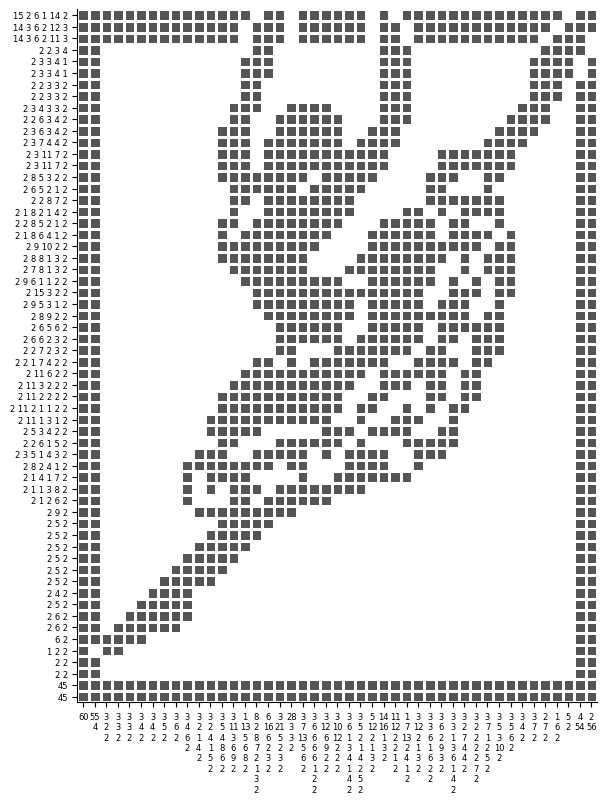

In [23]:
from helper.plot import plot_nonogram_board
plot_nonogram_board(puzzle, result, font_size=6);